In [1]:
# keras相关包
from tensorflow.keras.applications import ResNet50
from keras.layers import Flatten
from keras.layers import Dense
from keras.layers import Input
from keras.models import Model
from tensorflow.keras.optimizers import SGD
from keras.preprocessing.image import ImageDataGenerator
from keras.callbacks import ModelCheckpoint
from keras.preprocessing.image import load_img
from keras.preprocessing.image import img_to_array

# sklearn相关包
from sklearn.metrics import classification_report
from sklearn.preprocessing import LabelBinarizer
from sklearn.feature_extraction.image import extract_patches_2d

import numpy as np
import cv2
import os
from imutils import paths
import progressbar

# 作图
import matplotlib.pyplot as plt
%matplotlib inline

In [2]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [3]:
#设置随机种子
np.random.seed(161)

from keras.datasets import cifar10

#读取数据集
(x_train, y_train), (x_test, y_test) = cifar10.load_data()

#归一化
x_train = x_train / 255.0
x_test = x_test / 255.0

170508288/170498071 [==============================] - 4s 0us/step


In [4]:
train_classes, train_class_counts = np.unique(y_train, return_counts=True)
nb_train_classes = len(train_classes)
imbal_class_counts = [500, 1000] * 5

class_indices = [np.where(y_train == i)[0] for i in range(nb_train_classes)]

In [5]:
imbal_class_indices = [class_idx[:class_count] for class_idx, class_count in zip(class_indices, imbal_class_counts)]
imbal_class_indices = np.hstack(imbal_class_indices)

y_train = y_train[imbal_class_indices]
x_train = x_train[imbal_class_indices]

In [6]:
len(x_train)

7500

In [7]:
from keras.utils.np_utils import to_categorical

# Y 热编码
y_train_oh = to_categorical(y_train)
y_test_oh = to_categorical(y_test)

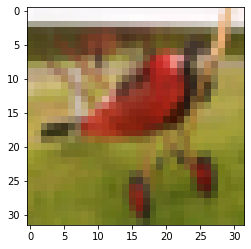

In [8]:
plt.imshow(x_train[2])
plt.show()

In [17]:
# 加载不包含top层的ResNet50作为baseModel
baseModel = ResNet50(weights="imagenet", include_top=False, input_tensor=Input(shape=(32, 32, 3)))

In [18]:

def headmodel(baseModel):
    # 在baseModel基础上添加新的层
    headModel = baseModel.output
    
    # 新的 top 层
    headModel = Flatten()(headModel)
    headModel = Dense(10, activation="softmax")(headModel)

    return headModel

In [19]:
headModel = headmodel(baseModel)
model = Model(inputs=baseModel.input, outputs=headModel)


In [ ]:
# #图片增广
# # 首先利用ImageDataGenerator类实例化一个图像生成器对象，设置图片增广相关的参数。
# aug = ImageDataGenerator(rotation_range=30,
#                          width_shift_range=0.1,
#                          height_shift_range=0.1, 
#                          shear_range=0.2, 
#                          zoom_range=0.2,
#                          horizontal_flip=True,
#                          fill_mode="nearest")

In [20]:
# 保存模型快照的回调函数
modelname = "cifar10-resnet50-weights-{epoch:03d}-{val_loss:.4f}.hdf5"
checkpoint = ModelCheckpoint(modelname, monitor="val_loss", mode="min", save_best_only=True)

In [21]:
# 模型编译¶
# 编译模型需要指定优化器算法，loss函数和评估指标。之前的案例一直是二分类问题，所以loss函数使用的是binary_crossentropy，现在是多分类问题，loss函数使用categorical_crossentropy。

# 冻结住baseModel所有层的参数不学习
for layer in baseModel.layers:
    layer.trainable = False

In [22]:
# 编译
sgd = SGD(lr=0.01, decay=0.01 / 20, momentum=0.9, nesterov=True)
model.compile(loss="categorical_crossentropy", optimizer=sgd,metrics=["accuracy"])

/usr/local/lib/python3.7/dist-packages/keras/optimizer_v2/optimizer_v2.py:356: UserWarning: The `lr` argument is deprecated, use `learning_rate` instead.
  "The `lr` argument is deprecated, use `learning_rate` instead.")


In [23]:
H = model.fit(x_train, y_train_oh, batch_size=32,
                        validation_data=(x_test, y_test_oh),
                        callbacks=[checkpoint],
                        epochs=20)

Epoch 1/20
235/235 [==============================] - 70s 284ms/step - loss: 43.5335 - accuracy: 0.1237 - val_loss: 32.5558 - val_accuracy: 0.1001


/usr/local/lib/python3.7/dist-packages/keras/utils/generic_utils.py:497: CustomMaskWarning: Custom mask layers require a config and must override get_config. When loading, the custom mask layer must be passed to the custom_objects argument.
  category=CustomMaskWarning)


Epoch 2/20
235/235 [==============================] - ETA: 0s - loss: 27.7476 - accuracy: 0.1584

KeyboardInterrupt: ignored

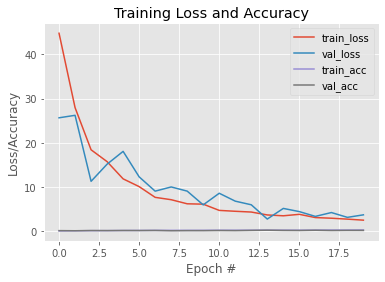

In [ ]:
# 绘制loss和accuracy曲线
plt.style.use("ggplot")
plt.figure()
plt.plot(np.arange(0, 20), H.history["loss"], label="train_loss")
plt.plot(np.arange(0, 20), H.history["val_loss"], label="val_loss")
plt.plot(np.arange(0, 20), H.history["accuracy"], label="train_acc")
plt.plot(np.arange(0, 20), H.history["val_accuracy"], label="val_acc")
plt.title("Training Loss and Accuracy")
plt.xlabel("Epoch #")
plt.ylabel("Loss/Accuracy")
plt.legend()
plt.show()

In [ ]:
# 分类评估报告
preds = model.predict(x_test, batch_size=32)
print(classification_report(y_test_oh.argmax(axis=1),preds.argmax(axis=1), digits=4))

#  target_names=labelNames

              precision    recall  f1-score   support

           0     0.6009    0.1370    0.2231      1000
           1     0.3590    0.5460    0.4332      1000
           2     0.3205    0.0250    0.0464      1000
           3     0.0000    0.0000    0.0000      1000
           4     0.4242    0.0140    0.0271      1000
           5     0.6154    0.0160    0.0312      1000
           6     0.3636    0.0160    0.0307      1000
           7     0.1436    0.9460    0.2494      1000
           8     0.3885    0.5680    0.4614      1000
           9     0.8095    0.0170    0.0333      1000

    accuracy                         0.2285     10000
   macro avg     0.4025    0.2285    0.1536     10000
weighted avg     0.4025    0.2285    0.1536     10000



/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classification.py:1272: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
